In [1]:
import typing
import gc
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
X_idx = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]

In [3]:
train, valid, test = (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :])

In [12]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_idx], train)
    Y_hat = lasso_model.predict(valid[:, X_idx])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.001
Computing validation loss for alpha = 0.004105263157894737
Computing validation loss for alpha = 0.007210526315789474
Computing validation loss for alpha = 0.010315789473684212
Computing validation loss for alpha = 0.013421052631578948
Computing validation loss for alpha = 0.016526315789473684
Computing validation loss for alpha = 0.019631578947368424
Computing validation loss for alpha = 0.02273684210526316
Computing validation loss for alpha = 0.025842105263157895
Computing validation loss for alpha = 0.02894736842105263
Computing validation loss for alpha = 0.03205263157894737
Computing validation loss for alpha = 0.0351578947368421
Computing validation loss for alpha = 0.038263157894736846
Computing validation loss for alpha = 0.04136842105263158
Computing validation loss for alpha = 0.04447368421052632
Computing validation loss for alpha = 0.047578947368421054
Computing validation loss for alpha = 0.05068421052631579
Computing validation

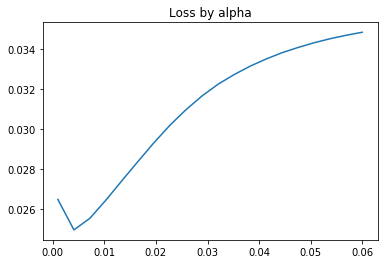

In [13]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [14]:
lasso_model = Lasso(alphas[1]).fit(train[:, X_idx], train)

In [15]:
Y_hat = lasso_model.predict(test[:, X_idx])
print("Final test loss (mse): {}".format(mean_squared_error(Y_hat, test)))

Final test loss (mse): 0.026553129235773236


### Is X compressible?

In [16]:
from sklearn.decomposition import PCA

In [29]:
pca_model = PCA().fit(train[:, X_idx])

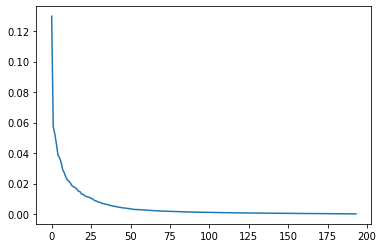

In [32]:
plt.plot(pca_model.explained_variance_ratio_)

In [34]:
# sanity check
sum(pca_model.explained_variance_ratio_)

1.0000000000000002